In [2]:
import sys
sys.path.append("../")
from MiniTransformersModels.MiniGpt import MiniGPt
import torch

Generating Training Data


In [1]:
import random
import numpy as np

# ==========================================
# OPTION 1: Séquences arithmétiques simples
# ==========================================

def generate_arithmetic_sequences(n_samples=1000, seq_len=7, max_num=20):
    """
    Génère des séquences arithmétiques cohérentes
    Exemple: [2, 4, 6, 8, 10, 12, 14]
    Le modèle doit prédire le nombre suivant
    """
    vocab = {
        0: "<PAD>", 1: "<START>", 2: "<END>",
        **{i+3: str(i) for i in range(max_num)}  # 3-22 pour les nombres 0-19
    }
    vocab_size = len(vocab)
    word_to_id = {v: k for k, v in vocab.items()}
    
    sequences = []
    
    for _ in range(n_samples):
        # Choisir un début et un pas aléatoires
        start = random.randint(0, max_num - seq_len - 1)
        step = random.randint(1, 3)
        
        # Créer la séquence
        seq = [word_to_id["<START>"]]
        for i in range(seq_len - 2):
            num = start + i * step
            if num < max_num:
                seq.append(word_to_id[str(num)])
        seq.append(word_to_id["<END>"])
        
        # Padding si nécessaire
        while len(seq) < seq_len:
            seq.append(word_to_id["<PAD>"])
        
        sequences.append(seq[:seq_len])
    
    return torch.tensor(sequences, dtype=torch.long), vocab_size, vocab


# ==========================================
# OPTION 2: Phrases simples avec grammaire
# ==========================================

def generate_simple_sentences(n_samples=1000, seq_len=10):
    """
    Génère des phrases simples avec une grammaire basique
    Exemple: "the cat is big"
    """
    vocab = {
        0: "<PAD>", 1: "<START>", 2: "<END>",
        3: "the", 4: "a", 5: "is", 6: "are",
        7: "cat", 8: "dog", 9: "fish", 10: "bird",
        11: "big", 12: "small", 13: "red", 14: "blue",
        15: "runs", 16: "jumps", 17: "swims", 18: "flies",
        19: "and", 20: "or", 21: "with", 22: "has"
    }
    vocab_size = len(vocab)
    word_to_id = {v: k for k, v in vocab.items()}
    
    # Templates de phrases
    templates = [
        ["the", "{animal}", "is", "{adj}"],
        ["a", "{animal}", "{verb}"],
        ["the", "{adj}", "{animal}", "{verb}"],
        ["{animal}", "is", "{adj}", "and", "{adj}"],
        ["the", "{animal}", "has", "{adj}", "{animal}"],
    ]
    
    animals = ["cat", "dog", "fish", "bird"]
    adjectives = ["big", "small", "red", "blue"]
    verbs = ["runs", "jumps", "swims", "flies"]
    
    sequences = []
    
    for _ in range(n_samples):
        # Choisir un template aléatoire
        template = random.choice(templates)
        
        # Remplir le template
        sentence = [word_to_id["<START>"]]
        for word in template:
            if word == "{animal}":
                sentence.append(word_to_id[random.choice(animals)])
            elif word == "{adj}":
                sentence.append(word_to_id[random.choice(adjectives)])
            elif word == "{verb}":
                sentence.append(word_to_id[random.choice(verbs)])
            else:
                sentence.append(word_to_id[word])
        sentence.append(word_to_id["<END>"])
        
        # Padding
        while len(sentence) < seq_len:
            sentence.append(word_to_id["<PAD>"])
        
        sequences.append(sentence[:seq_len])
    
    return torch.tensor(sequences, dtype=torch.long), vocab_size, vocab


# ==========================================
# OPTION 3: Séquences de répétition
# ==========================================

def generate_repeat_patterns(n_samples=1000, seq_len=10, n_symbols=10):
    """
    Génère des patterns de répétition
    Exemple: [A, B, C, A, B, C, A, B, C]
    Le modèle doit apprendre le pattern
    """
    vocab = {
        0: "<PAD>", 1: "<START>", 2: "<END>",
        **{i+3: f"SYM_{i}" for i in range(n_symbols)}
    }
    vocab_size = len(vocab)
    
    sequences = []
    
    for _ in range(n_samples):
        # Choisir un pattern aléatoire
        pattern_len = random.randint(2, 4)
        pattern = [random.randint(3, vocab_size - 1) for _ in range(pattern_len)]
        
        # Répéter le pattern
        seq = [1]  # <START>
        repeats = (seq_len - 3) // pattern_len + 1
        for _ in range(repeats):
            seq.extend(pattern)
        seq = seq[:seq_len - 1]
        seq.append(2)  # <END>
        
        # Padding
        while len(seq) < seq_len:
            seq.append(0)
        
        sequences.append(seq[:seq_len])
    
    return torch.tensor(sequences, dtype=torch.long), vocab_size, vocab


# ==========================================
# OPTION 4: Séquences inversées (tâche de copie)
# ==========================================

def generate_reverse_sequences(n_samples=1000, seq_len=12, n_symbols=15):
    """
    Génère des séquences à inverser
    Input: [A, B, C, D] -> Output: [D, C, B, A]
    """
    vocab = {
        0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<SEP>",
        **{i+4: f"TOK_{i}" for i in range(n_symbols)}
    }
    vocab_size = len(vocab)
    
    sequences = []
    
    for _ in range(n_samples):
        # Générer une séquence aléatoire
        length = random.randint(3, 5)
        original = [random.randint(4, vocab_size - 1) for _ in range(length)]
        
        # Créer: <START> original <SEP> reversed <END>
        seq = [1] + original + [3] + original[::-1] + [2]
        
        # Padding
        while len(seq) < seq_len:
            seq.append(0)
        
        sequences.append(seq[:seq_len])
    
    return torch.tensor(sequences, dtype=torch.long), vocab_size, vocab


# ==========================================
# OPTION 5: Données de dialogue simple
# ==========================================

def generate_qa_pairs(n_samples=1000, seq_len=15):
    """
    Génère des paires question-réponse simples
    """
    vocab = {
        0: "<PAD>", 1: "<START>", 2: "<END>",
        3: "what", 4: "is", 5: "the", 6: "color", 7: "of",
        8: "cat", 9: "dog", 10: "sky", 11: "grass",
        12: "red", 13: "blue", 14: "green", 15: "yellow",
        16: "brown", 17: "gray", 18: "?", 19: "it"
    }
    vocab_size = len(vocab)
    word_to_id = {v: k for k, v in vocab.items()}
    
    # Règles: cat->gray, dog->brown, sky->blue, grass->green
    rules = {
        "cat": "gray", "dog": "brown", 
        "sky": "blue", "grass": "green"
    }
    
    sequences = []
    
    for _ in range(n_samples):
        # Choisir un objet
        obj = random.choice(list(rules.keys()))
        answer = rules[obj]
        
        # Créer: "what is the color of {obj} ? it is {answer}"
        seq = [
            word_to_id["<START>"],
            word_to_id["what"], word_to_id["is"], word_to_id["the"],
            word_to_id["color"], word_to_id["of"], word_to_id[obj],
            word_to_id["?"], word_to_id["it"], word_to_id["is"],
            word_to_id[answer], word_to_id["<END>"]
        ]
        
        # Padding
        while len(seq) < seq_len:
            seq.append(word_to_id["<PAD>"])
        
        sequences.append(seq[:seq_len])
    
    return torch.tensor(sequences, dtype=torch.long), vocab_size, vocab


# ==========================================
# FONCTION DE PRÉPARATION POUR GPT
# ==========================================

def prepare_gpt_data(sequences, test_ratio=0.25):
    """
    Prépare les données pour l'entraînement GPT
    X: séquence[:-1] (input)
    Y: séquence[1:] (target, décalé d'un token)
    """
    n_samples = len(sequences)
    n_test = int(n_samples * test_ratio)
    
    # Mélanger les données
    indices = torch.randperm(n_samples)
    sequences = sequences[indices]
    
    # Séparer train/test
    train_seq = sequences[:-n_test]
    test_seq = sequences[-n_test:]
    
    # Créer X (input) et Y (target)
    x_train = train_seq[:, :-1]
    y_train = train_seq[:, 1:]
    x_test = test_seq[:, :-1]
    y_test = test_seq[:, 1:]
    
    return x_train, y_train, x_test, y_test


# ==========================================
# EXEMPLES D'UTILISATION
# ==========================================


Training on Data 1

In [3]:
print("=" * 60)
print("OPTION 1: Séquences arithmétiques")
print("=" * 60)
sequences, vocab_size, vocab = generate_arithmetic_sequences(1000, seq_len=10)
x_train, y_train, x_test, y_test = prepare_gpt_data(sequences)
print(f"Vocab size: {vocab_size}")
print(f"X_train: {x_train.shape}, Y_train: {y_train.shape}")
print(f"X_test: {x_test.shape}, Y_test: {y_test.shape}")
print(f"Exemple de séquence: {sequences[0].tolist()}")
print(f"Décodé: {[vocab[i.item()] for i in sequences[0] if i.item() != 0]}")

OPTION 1: Séquences arithmétiques
Vocab size: 23
X_train: torch.Size([750, 9]), Y_train: torch.Size([750, 9])
X_test: torch.Size([250, 9]), Y_test: torch.Size([250, 9])
Exemple de séquence: [1, 10, 12, 14, 16, 18, 20, 22, 2, 0]
Décodé: ['<START>', '7', '9', '11', '13', '15', '17', '19', '<END>']


In [10]:
y_test.shape

torch.Size([250, 9])

In [13]:
gpt=MiniGPt("adam","Crossentropy",vocab_size,128)  
train_losses,val_losses,accs,val_accs=gpt.minibatch_SGD_train(10,x_train,torch.eye(23)[y_train],x_test,torch.eye(23)[y_test],batch_size=32,learning_rate=0.001,accuracy=True)

1 | Train Loss: 0.1031 | Val Loss: 0.0847 | Train Acc: 10.04% | Val Acc: 16.50%
2 | Train Loss: 0.0849 | Val Loss: 0.0722 | Train Acc: 16.29% | Val Acc: 27.25%
3 | Train Loss: 0.0722 | Val Loss: 0.0622 | Train Acc: 27.23% | Val Acc: 36.33%
4 | Train Loss: 0.0621 | Val Loss: 0.0539 | Train Acc: 36.88% | Val Acc: 41.69%
5 | Train Loss: 0.0537 | Val Loss: 0.0471 | Train Acc: 42.19% | Val Acc: 43.76%
6 | Train Loss: 0.0469 | Val Loss: 0.0410 | Train Acc: 43.52% | Val Acc: 45.08%
7 | Train Loss: 0.0408 | Val Loss: 0.0358 | Train Acc: 45.19% | Val Acc: 48.57%
8 | Train Loss: 0.0356 | Val Loss: 0.0315 | Train Acc: 48.04% | Val Acc: 50.28%
9 | Train Loss: 0.0314 | Val Loss: 0.0276 | Train Acc: 50.40% | Val Acc: 50.66%
10 | Train Loss: 0.0275 | Val Loss: 0.0245 | Train Acc: 50.99% | Val Acc: 51.62%


Ploting the results


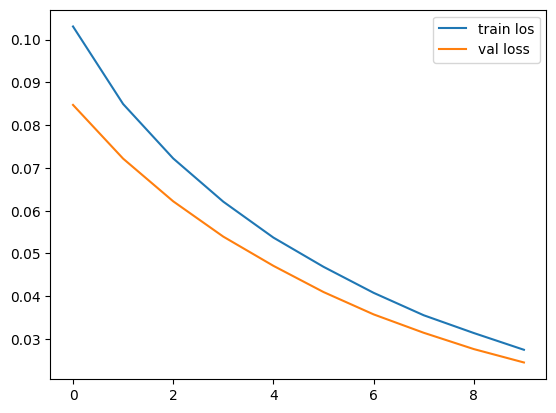

In [15]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)),train_losses,label="train los")
plt.plot(range(len(train_losses)),val_losses,label="val loss")
plt.legend()



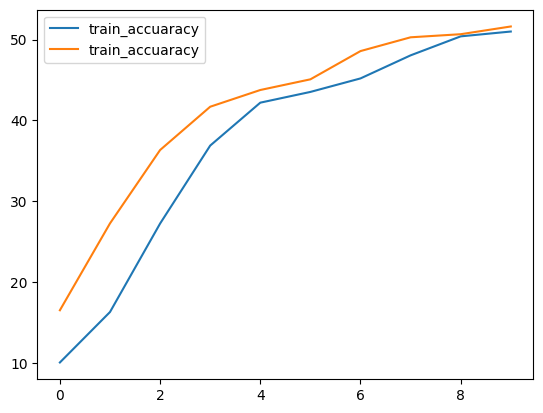

In [16]:
plt.plot(range(len(train_losses)),accs,label="train_accuaracy")
plt.plot(range(len(train_losses)),val_accs,label="train_accuaracy")
plt.legend()

Training on Data 2


In [18]:
print("\n" + "=" * 60)
print("OPTION 2: Phrases simples")
print("=" * 60)
sequences, vocab_size, vocab = generate_simple_sentences(1000, seq_len=10)
x_train2, y_train2, x_test2, y_test2 = prepare_gpt_data(sequences)
print(f"Vocab size: {vocab_size}")
print(f"X_train: {x_train2.shape}, Y_train: {y_train2.shape}")
print(f"Exemple de séquence: {[vocab[i.item()] for i in sequences[0] if i.item() != 0]}")


OPTION 2: Phrases simples
Vocab size: 23
X_train: torch.Size([750, 9]), Y_train: torch.Size([750, 9])
Exemple de séquence: ['<START>', 'bird', 'is', 'big', 'and', 'small', '<END>']


In [20]:
gpt=MiniGPt("adam","Crossentropy",vocab_size,128)  
train_losses,val_losses,accs,val_accs=gpt.minibatch_SGD_train(10,x_train2,torch.eye(vocab_size)[y_train2],x_test2,torch.eye(vocab_size)[y_test2],batch_size=32,learning_rate=0.001,accuracy=True)

1 | Train Loss: 0.1010 | Val Loss: 0.0809 | Train Acc: 15.37% | Val Acc: 21.13%
2 | Train Loss: 0.0801 | Val Loss: 0.0704 | Train Acc: 21.44% | Val Acc: 27.46%
3 | Train Loss: 0.0694 | Val Loss: 0.0637 | Train Acc: 27.68% | Val Acc: 31.65%
4 | Train Loss: 0.0627 | Val Loss: 0.0587 | Train Acc: 31.86% | Val Acc: 31.29%
5 | Train Loss: 0.0577 | Val Loss: 0.0550 | Train Acc: 31.99% | Val Acc: 29.95%
6 | Train Loss: 0.0540 | Val Loss: 0.0519 | Train Acc: 30.94% | Val Acc: 31.79%
7 | Train Loss: 0.0508 | Val Loss: 0.0492 | Train Acc: 32.70% | Val Acc: 31.72%
8 | Train Loss: 0.0481 | Val Loss: 0.0469 | Train Acc: 32.50% | Val Acc: 32.87%
9 | Train Loss: 0.0459 | Val Loss: 0.0450 | Train Acc: 33.55% | Val Acc: 33.69%
10 | Train Loss: 0.0440 | Val Loss: 0.0432 | Train Acc: 34.52% | Val Acc: 33.29%


ploting the results

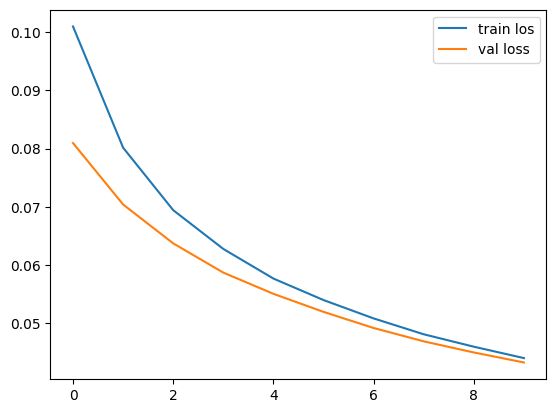

In [21]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)),train_losses,label="train los")
plt.plot(range(len(train_losses)),val_losses,label="val loss")
plt.legend()



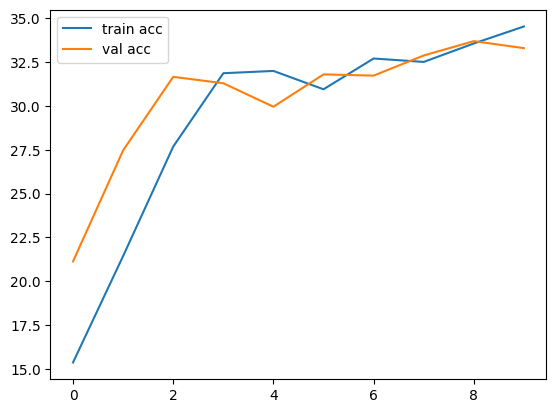

In [22]:
plt.plot(range(len(train_losses)),accs,label="train acc")
plt.plot(range(len(train_losses)),val_accs,label="val acc")
plt.legend()

Training on Data 3

In [3]:

print("\n" + "=" * 60)
print("OPTION 3: Patterns de répétition")
print("=" * 60)
sequences, vocab_size, vocab = generate_repeat_patterns(1000, seq_len=12)
x_train3, y_train3, x_test3, y_test3 = prepare_gpt_data(sequences)
print(f"Vocab size: {vocab_size}")
print(f"X_train: {x_train3.shape}, Y_train: {y_train3.shape}")
print(f"Exemple: {sequences[0].tolist()}")


OPTION 3: Patterns de répétition
Vocab size: 13
X_train: torch.Size([750, 11]), Y_train: torch.Size([750, 11])
Exemple: [1, 10, 9, 3, 10, 9, 3, 10, 9, 3, 10, 2]


In [4]:
gpt=MiniGPt("adam","Crossentropy",vocab_size,128)  
train_losses,val_losses,accs,val_accs=gpt.minibatch_SGD_train(10,x_train3,torch.eye(vocab_size)[y_train3],x_test3,torch.eye(vocab_size)[y_test3],batch_size=32,learning_rate=0.001,accuracy=True)

1 | Train Loss: 0.1974 | Val Loss: 0.1802 | Train Acc: 13.85% | Val Acc: 11.02%
2 | Train Loss: 0.1797 | Val Loss: 0.1734 | Train Acc: 11.09% | Val Acc: 13.02%
3 | Train Loss: 0.1730 | Val Loss: 0.1700 | Train Acc: 13.22% | Val Acc: 11.26%
4 | Train Loss: 0.1692 | Val Loss: 0.1677 | Train Acc: 12.33% | Val Acc: 10.55%
5 | Train Loss: 0.1664 | Val Loss: 0.1657 | Train Acc: 12.13% | Val Acc: 11.35%
6 | Train Loss: 0.1643 | Val Loss: 0.1651 | Train Acc: 12.58% | Val Acc: 11.78%
7 | Train Loss: 0.1636 | Val Loss: 0.1640 | Train Acc: 12.59% | Val Acc: 12.00%
8 | Train Loss: 0.1623 | Val Loss: 0.1631 | Train Acc: 12.90% | Val Acc: 12.09%
9 | Train Loss: 0.1612 | Val Loss: 0.1622 | Train Acc: 13.24% | Val Acc: 12.77%
10 | Train Loss: 0.1602 | Val Loss: 0.1613 | Train Acc: 13.42% | Val Acc: 13.29%


Ploting the results 

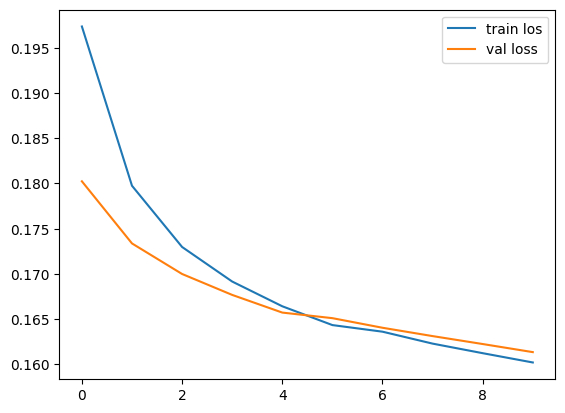

In [5]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)),train_losses,label="train los")
plt.plot(range(len(train_losses)),val_losses,label="val loss")
plt.legend()



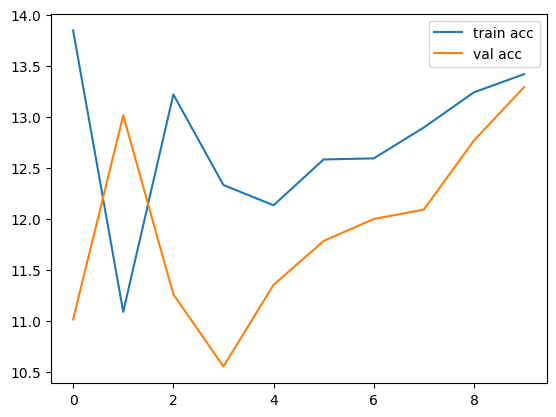

In [6]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)),accs,label="train acc")
plt.plot(range(len(train_losses)),val_accs,label="val acc")
plt.legend()

Training on Data 4

In [8]:
print("\n" + "=" * 60)
print("OPTION 4: Séquences inversées")
print("=" * 60)
sequences, vocab_size, vocab = generate_reverse_sequences(1000, seq_len=14)
x_train4, y_train4, x_test4, y_test4 = prepare_gpt_data(sequences)
print(f"Vocab size: {vocab_size}")
print(f"X_train: {x_train4.shape}, Y_train: {y_test4.shape}")
print(f"Exemple: {sequences[0].tolist()}")


OPTION 4: Séquences inversées
Vocab size: 19
X_train: torch.Size([750, 13]), Y_train: torch.Size([250, 13])
Exemple: [1, 18, 10, 4, 8, 3, 8, 4, 10, 18, 2, 0, 0, 0]


In [11]:
gpt=MiniGPt("adam","Crossentropy",vocab_size,128)  
train_losses,val_losses,accs,val_accs=gpt.minibatch_SGD_train(10,x_train4,torch.eye(vocab_size)[y_train4],x_test4,torch.eye(vocab_size)[y_test4],batch_size=32,learning_rate=0.001,accuracy=True)

1 | Train Loss: 0.1455 | Val Loss: 0.1300 | Train Acc: 6.81% | Val Acc: 12.99%
2 | Train Loss: 0.1303 | Val Loss: 0.1228 | Train Acc: 12.54% | Val Acc: 15.05%
3 | Train Loss: 0.1228 | Val Loss: 0.1192 | Train Acc: 14.95% | Val Acc: 18.74%
4 | Train Loss: 0.1188 | Val Loss: 0.1165 | Train Acc: 18.39% | Val Acc: 24.34%
5 | Train Loss: 0.1159 | Val Loss: 0.1141 | Train Acc: 22.80% | Val Acc: 27.24%
6 | Train Loss: 0.1136 | Val Loss: 0.1123 | Train Acc: 26.50% | Val Acc: 29.03%
7 | Train Loss: 0.1116 | Val Loss: 0.1110 | Train Acc: 28.74% | Val Acc: 28.93%
8 | Train Loss: 0.1101 | Val Loss: 0.1099 | Train Acc: 29.08% | Val Acc: 28.59%
9 | Train Loss: 0.1088 | Val Loss: 0.1089 | Train Acc: 29.47% | Val Acc: 26.86%
10 | Train Loss: 0.1075 | Val Loss: 0.1078 | Train Acc: 27.82% | Val Acc: 23.79%


ploting the results

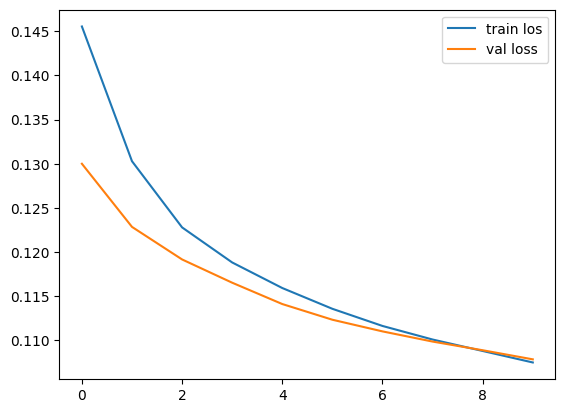

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)),train_losses,label="train los")
plt.plot(range(len(train_losses)),val_losses,label="val loss")
plt.legend()



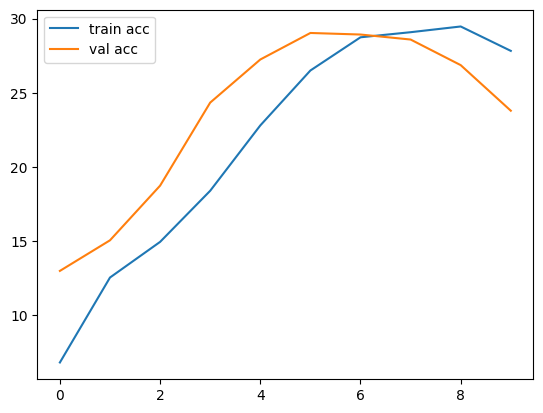

In [15]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)),accs,label="train acc")
plt.plot(range(len(train_losses)),val_accs,label="val acc")
plt.legend()

Training on Data 5

In [16]:

print("\n" + "=" * 60)
print("OPTION 5: Question-Réponse")
print("=" * 60)
sequences, vocab_size, vocab = generate_qa_pairs(1000, seq_len=15)
x_train5, y_train5, x_test5, y_test5 = prepare_gpt_data(sequences)
print(f"Vocab size: {vocab_size}")
print(f"X_train: {x_train5.shape}, Y_train: {y_train5.shape}")
print(f"Exemple: {[vocab[i.item()] for i in sequences[0] if i.item() != 0]}")


OPTION 5: Question-Réponse
Vocab size: 20
X_train: torch.Size([750, 14]), Y_train: torch.Size([750, 14])
Exemple: ['<START>', 'what', 'is', 'the', 'color', 'of', 'sky', '?', 'it', 'is', 'blue', '<END>']


In [17]:
gpt=MiniGPt("adam","Crossentropy",vocab_size,128)  
train_losses,val_losses,accs,val_accs=gpt.minibatch_SGD_train(10,x_train5,torch.eye(vocab_size)[y_train5],x_test5,torch.eye(vocab_size)[y_test5],batch_size=32,learning_rate=0.001,accuracy=True)

1 | Train Loss: 0.1425 | Val Loss: 0.0953 | Train Acc: 7.42% | Val Acc: 23.48%
2 | Train Loss: 0.0950 | Val Loss: 0.0690 | Train Acc: 23.74% | Val Acc: 33.66%
3 | Train Loss: 0.0687 | Val Loss: 0.0545 | Train Acc: 33.76% | Val Acc: 38.48%
4 | Train Loss: 0.0542 | Val Loss: 0.0451 | Train Acc: 38.74% | Val Acc: 43.66%
5 | Train Loss: 0.0449 | Val Loss: 0.0388 | Train Acc: 43.74% | Val Acc: 42.14%
6 | Train Loss: 0.0386 | Val Loss: 0.0343 | Train Acc: 42.44% | Val Acc: 42.14%
7 | Train Loss: 0.0342 | Val Loss: 0.0310 | Train Acc: 42.46% | Val Acc: 43.48%
8 | Train Loss: 0.0309 | Val Loss: 0.0286 | Train Acc: 43.73% | Val Acc: 50.94%
9 | Train Loss: 0.0285 | Val Loss: 0.0270 | Train Acc: 51.31% | Val Acc: 52.86%
10 | Train Loss: 0.0269 | Val Loss: 0.0259 | Train Acc: 52.53% | Val Acc: 50.40%


ploting the results


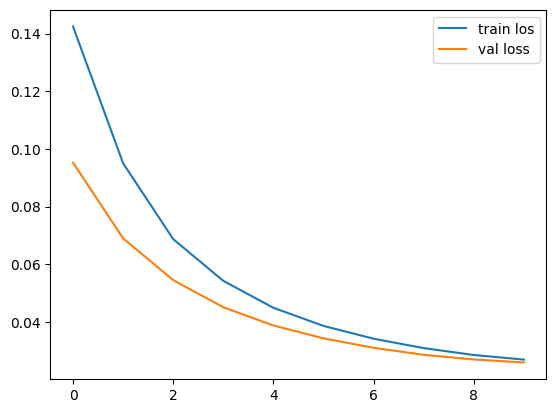

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)),train_losses,label="train los")
plt.plot(range(len(train_losses)),val_losses,label="val loss")
plt.legend()



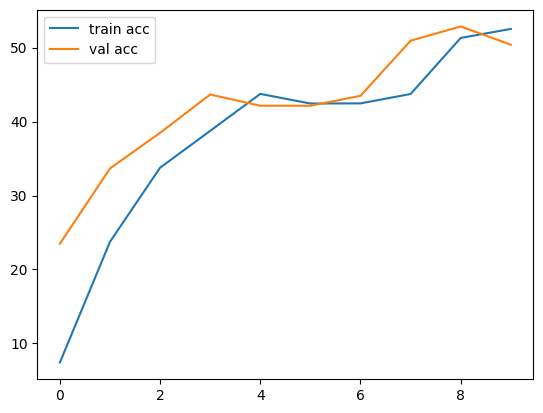

In [19]:
plt.plot(range(len(train_losses)),accs,label="train acc")
plt.plot(range(len(train_losses)),val_accs,label="val acc")
plt.legend()